In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
import sys
sys.path.append('/data/jinrong/wcw/PS/text-image-forgery-detection')
import torch.nn as nn
import torch
from tqdm import tqdm
import numpy as np
from view.MetricMonitor import MetricMonitor
from metric.Metric import *
from torch.utils.data import DataLoader
import random
from dataset.docudataset import *
from lossModel.MultLoss import WeightedDiceBCE
import time
from torchvision.utils import save_image
import yaml
from sklearn.metrics import roc_auc_score
torch.backends.cudnn.enabled = False
import shutil
from models.rrumodel import Ringed_Res_Unet
from models.mvsssnet import get_mvss

from models.CFLNet import CFLNet
import timm
from models import denseFCN
from models.Movenet7f4attention_adaption import Movenet
from models.Tifdm import Tifdm
import torch.nn.functional as F

/home/jinrong/anaconda3/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [33]:
random.seed(42)
parent_dir = '/data/jinrong/wcw/PS/text-image-forgery-detection/ckps/checkps/'
params = {
    "model_name":'Ours',
    #指定当前模式为“train” 或者 “predict”
    "mode":"train", #"train" , train,predict 
    "lr": 0.0001,
    "batch_size": 4,
    "test_batch_size":4,
    "num_workers": 4,
    "epochs": 1000000,
    "non_blocking_":True,
    "dataset_name":'season5_data', # season3_data,season5_data,season6_data,total_pb,DocTamper
}

# 
params["load_model_path"] = '/data/jinrong/wcw/PS/text-image-forgery-detection/cache'#best_acc+'_'+f1+'_'+iou+'_'+auc+'_'+epoch

params["save_model_path"] = os.path.join(parent_dir,'weight_{}_version.pth'.format(params["model_name"]))
params["save_dir"] = parent_dir

In [3]:
# 构建 DataLoader，这里是一个示例
# 可以根据实际情况使用 PyTorch、TensorFlow 或其他库来构建 DataLoader
# 这里只是演示如何使用索引来构建 DataLoader
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask = mask[:,:,0:1]
    mask[mask<=127.5] = 0.0
    mask[mask>127.5] = 255.
    #mask[mask<=127.5] = 255.
    #mask[mask>127.5] = 0.0
    return mask
class UNetDataset(Dataset):
    def __init__(self, dataTrain_list, dataMask_list, train_transform=None,val_transform=None,mode = 'train'):
        self.dataTrain_list = dataTrain_list
        self.dataMask_list = dataMask_list
        
        self.dataTrain_list.sort()
        self.dataMask_list.sort()
        
        self.mode = mode
        
        self.trainDataSize = len(self.dataTrain_list)
        self.maskDataSize = len(self.dataMask_list)

        self.transform1  = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        self.toTensor  = A.Compose([ToTensorV2()])
        if train_transform is not None:
            self.train_transform = train_transform
        else:
            self.train_transform = A.Compose(
                                [
                                    A.Resize(max_size_h,max_size_w,p=1),
                                    #A.RandomCrop(width=max_size, height=max_size,p=1),
                                    A.VerticalFlip(p=0.2),
                                    #A.RandomRotate90(p=0.5),
                                    A.HorizontalFlip(p = 0.2),
                                    #A.ImageCompression(quality_lower=50, quality_upper=100, p=0.5),
                                    #A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225), p=1),
                                    ToTensorV2(),
                                ]
                            )
        if val_transform is not None:
            self.val_transform = val_transform
        else:
            self.val_transform = A.Compose(
                                        [
                                            A.Resize(max_size_h,max_size_w,p=1),
                                            #A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225), p=1),
                                            ToTensorV2(),
                                        ]
                                    )
    
        self.kernel = np.ones((4, 4), np.uint8) 
        self.feature_chan = [128,64,32,16]
        
    def __getitem__(self, index):
        assert self.trainDataSize == self.maskDataSize
        image_filename = self.dataTrain_list[index]
        image = cv2.imread(image_filename)
     
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h,w,c = image.shape

        mask_filename = self.dataMask_list[index]
        mask = cv2.imread(mask_filename)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        mask = preprocess_mask(mask)

        if self.mode=='train':
            transformed = self.train_transform(image=image, mask=mask)
            image = transformed["image"]
            final_mask = transformed["mask"]

        else:
            transformed = self.val_transform(image=image, mask=mask)
            image = transformed["image"]    
            final_mask = transformed["mask"]

        image = image.float().div(255)
        final_mask = final_mask.float().div(255)
        final_mask = final_mask.permute(2, 0, 1)


        if self.mode=='train':
            return image, final_mask,image_filename
        if self.mode=='val':
            return image, final_mask,image_filename
        if self.mode=='predict':
            return image, final_mask,w,h,image_filename
        

    def __len__(self):
        return self.trainDataSize

In [11]:
torch.__version__

'2.3.0+cu121'

In [12]:
torch.cuda.is_available()

True

In [3]:
import os
import random

# 六个数据集的根目录
root_dirs = ['/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/patch/', 
             '/data/jinrong/wcw/PS/data/003_tianchi_2023TTI/train/tampered/patch',
            '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/patch',
             '/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/patch/',
#              '/data/jinrong/wcw/PS/data//006_DocTamperV1/pic_FCD/patch',
#              '/data/jinrong/wcw/PS/data//006_DocTamperV1/pic_SCD/patch'
            ]
train_index = []
valid_index = []
# 构建索引
for i, root_dir in enumerate(root_dirs):
    index = []
    image_dir = os.path.join(root_dir, 'image')
    label_dir = os.path.join(root_dir, 'label')
    image_files = os.listdir(image_dir)
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, image_file).replace('jpg','png')
        index.append((image_path, label_path, i))  # 添加图片路径和标签路径，以及数据集索引
    # 随机打乱索引
    random.seed(42)
    random.shuffle(index)
    # 分割索引为训练集和验证集
    train_size = int(0.8 * len(index))
    train_index = train_index + index[:train_size]
    valid_index = valid_index + index[train_size:]

In [4]:
#确认文件都存在
for aa in train_index:
    image_path,label_path,bb = aa
    if os.path.isfile(image_path):
        pass
    else:
        print(f"文件 {image_path} 不存在")
    if os.path.isfile(label_path):
        pass
    else:
        print(f"文件 {label_path} 不存在")
for aa in valid_index:
    image_path,label_path,bb = aa
    if os.path.isfile(image_path):
        pass
    else:
        print(f"文件 {image_path} 不存在")
    if os.path.isfile(label_path):
        pass
    else:
        print(f"文件 {label_path} 不存在")

In [5]:
#构建训练、验证集list
train_img_dir = []
train_label_dir = []
for aa in train_index:
    train_img_dir.append(aa[0])
    train_label_dir.append(aa[1])
valid_img_dir = []
valid_label_dir = []
for aa in valid_index:
    valid_img_dir.append(aa[0])
    valid_label_dir.append(aa[1])

In [6]:
#使用临时数据集测试代码：
tmp_train_img_dir = train_img_dir
tmp_train_label_dir = train_label_dir
tmp_valid_img_dir = valid_img_dir
tmp_valid_label_dir = valid_label_dir

In [7]:
train_dataset = UNetDataset(tmp_train_img_dir, tmp_train_label_dir,mode='train')
val_dataset = UNetDataset(tmp_valid_img_dir, tmp_valid_label_dir,mode='predict')

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not list

In [17]:
model = Tifdm()
model = model.cuda()
model = nn.DataParallel(model).cuda()
# Define optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [18]:
model.device_ids

[0]

In [19]:
from datetime import datetime
now = datetime.now()
formatted_datetime = now.strftime('%Y%m%d_%H%M%S')
formatted_datetime

'20240505_115407'

In [20]:
parent_dir = '/data/jinrong/wcw/PS/text-image-forgery-detection/ckps'
params = {
        #指定当前模式为“train” 或者 “predict”
        "mode":"train", #"train" , train,predict 
        "lr": 0.0001,
        "batch_size": 4,
        "test_batch_size":2,
        "num_workers": 2,
        "epochs": 100,
        "non_blocking_":True,
        'model_name': 'Tifdm'
    }
params["load_model_path"] = '/data/jinrong/wcw/PS/text-image-forgery-detection/cache/efficientnet-b3-5fb5a3c3.pth'
params["save_model_path"] = os.path.join(parent_dir,formatted_datetime,'weight_{}_version.pth'.format(params["model_name"]))
params["save_dir"] = '/data/jinrong/wcw/PS/text-image-forgery-detection/ckps/predict_result'

In [6]:
# 暂时有问题
'''def load_model(model,params,optimizer):
    if os.path.exists(params):
        checkpoint = torch.load(params)
        #model.module.load_state_dict(checkpoint['model'], strict=True)
        model.load_state_dict(checkpoint['model'], strict=True)
        best_acc = checkpoint['best_acc']
        start_epoch = checkpoint['epoch']
        model_name = checkpoint['model_name']
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('The { '+model_name+' } model load weight successful!')
        return start_epoch,best_acc
    else:
        print('The model path is not exists. We will train the model from scratch.')
        return 1,0
ckp_path = '/data/jinrong/wcw/PS/text-image-forgery-detection/cache/efficientnet-b3-5fb5a3c3.pth'
start_epoch,best_acc = load_model(model,params['load_model_path'],optimizer)'''

"def load_model(model,params,optimizer):\n    if os.path.exists(params):\n        checkpoint = torch.load(params)\n        #model.module.load_state_dict(checkpoint['model'], strict=True)\n        model.load_state_dict(checkpoint['model'], strict=True)\n        best_acc = checkpoint['best_acc']\n        start_epoch = checkpoint['epoch']\n        model_name = checkpoint['model_name']\n        optimizer.load_state_dict(checkpoint['optimizer'])\n        print('The { '+model_name+' } model load weight successful!')\n        return start_epoch,best_acc\n    else:\n        print('The model path is not exists. We will train the model from scratch.')\n        return 1,0\nckp_path = '/data/jinrong/wcw/PS/text-image-forgery-detection/cache/efficientnet-b3-5fb5a3c3.pth'\nstart_epoch,best_acc = load_model(model,params['load_model_path'],optimizer)"

In [21]:
def save_model(model,optimizer,save_dir,params,epoch = 0,best_acc = 0,model_name = 'model_name',f1=0,iou=0,auc=0):
    
    if os.path.exists(save_dir)==False:
        os.makedirs(save_dir) 
    else:
        shutil.rmtree(save_dir)
        if os.path.exists(save_dir)==False:
            os.makedirs(save_dir) 
                    
    checkpoint = {
        'best_acc': best_acc,    
        'epoch': epoch,
        'model': model.state_dict(),
        'model_name':model_name,
        'optimizer':optimizer.state_dict(),
    }
    best_acc = round(best_acc,4)
    f1 = round(f1,4)
    iou = round(iou,4)
    auc = round(auc,4)
    best_acc = str(best_acc)
    f1 = str(f1)
    iou = str(iou)
    auc = str(auc)
    epoch = str(epoch)
    params =params.replace('version', best_acc+'_'+f1+'_'+iou+'_'+auc+'_'+epoch)
    torch.save(checkpoint, params)
    print('Time: {}, save weight successful! Best score is:{}'.format(time.strftime('%H:%M:%S', time.localtime()),best_acc))


In [41]:
def cal_score(tmp_valid_label_dir,save_dir):
    dir_1 = save_dir #预测值
    file_list_1 = os.listdir(dir_1) #预测值
    file_list_1.sort()#预测值
    file_list_2 = tmp_valid_label_dir
    file_list_2.sort()#label
    f1_list = []
    iou_list = []
    auc_list = []

    stream = tqdm(file_list_1,desc='processing',colour='CYAN')
    for i,_ in enumerate(stream, start=0):
        file_path_1 = os.path.join(dir_1,file_list_1[i])
        file_path_2 = file_list_2[i]

        img_1 = cv2.imread(file_path_1,cv2.IMREAD_GRAYSCALE)
        img_2 = cv2.imread(file_path_2,cv2.IMREAD_GRAYSCALE)
        h,w = img_1.shape
        h_,w_ = img_2.shape
        if h!=h_ or w!=w_:
            img_2 = cv2.resize(img_2,(w,h))

        img_1 = img_1/255.
        img_2 = img_2/255.
        img_1[img_1>=0.5] = 1
        img_1[img_1<0.5] = 0

        img_2_temp = img_2
        img_2_temp[img_2_temp>=0.5] = 1
        img_2_temp[img_2_temp<0.5] = 0
        # 计算f1 score 和 iou score
        f1,iou = metric_numpy(img_1,img_2_temp)
        
        # 计算auc
        img_1_ = img_1.flatten()
        img_2_ = img_2.flatten()
        try:
             # 计算auc score
            auc = roc_auc_score(img_2_,img_1_)
            auc_list.append(auc)
        except ValueError:
            pass
        
        f1_list.append(f1)
        iou_list.append(iou)

    f1_avg = np.mean(f1_list)     
    iou_avg = np.mean(iou_list)
    auc_avg = np.mean(auc_list)
    #auc_avg = 0
    score = f1_avg + iou_avg
    return score,f1_avg,iou_avg,auc_avg

def train(train_loader, model, criterion1,optimizer, epoch, params,criterion_2,global_step):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader,desc='processing',colour='CYAN')

    for i, (images, masks,_) in enumerate(stream, start=1):

        images = images.cuda(non_blocking=params['non_blocking_'])#非阻塞的，数据转移将不会等待GPU完成之前的操作
        masks = masks.cuda(non_blocking=params['non_blocking_'])

        reg_outs = model(images)
        reg_outs = torch.sigmoid(reg_outs)
        
        loss_region = criterion1(reg_outs, masks)

        optimizer.zero_grad()
        loss_region.backward()

        optimizer.step()

        global_step += 1

        metric_monitor.update("Loss", loss_region.item())
        stream.set_description(
            "Epoch: {epoch}. Train. {metric_monitor} Time: {time}".format(epoch=epoch, metric_monitor=metric_monitor,time=time.strftime('%H:%M:%S', time.localtime()))
        )

def predict(val_loader, model, params,threshold):
    model.eval()
    stream = tqdm(val_loader,desc='processing',colour='CYAN')
    with torch.no_grad():
        avg_dice_list = []
        avg_iou_list = []
        for step, (batch_x_val,batch_y_val,w_s, h_s, name) in enumerate(stream, start=1):
            masks = batch_y_val
            batch_x_val = batch_x_val.cuda(non_blocking=params['non_blocking_'])
            masks = masks.cuda(non_blocking=params['non_blocking_'])

            output_val = model(batch_x_val)

            batch_x_val_h_flip = batch_x_val.clone().detach()
            batch_x_val_h_flip = torch.flip(batch_x_val_h_flip,[3])

            batch_x_val_v_flip = batch_x_val.clone().detach()
            batch_x_val_v_flip = torch.flip(batch_x_val_v_flip,[2])

            image_h_flip = model(batch_x_val_h_flip)
            image_v_flip = model(batch_x_val_v_flip)
            image_h_flip = torch.flip(image_h_flip,[3])
            image_v_flip = torch.flip(image_v_flip,[2])
            
            result_output_1 = (output_val+image_h_flip+image_v_flip)/3.
    
            result_output = result_output_1
            result_output = torch.sigmoid(result_output)
            for i in range(len(result_output)):
                orig_w = w_s[i]
                orig_h = h_s[i]
                result_output_ = F.interpolate(result_output[i:i+1], size=[orig_h,orig_w], mode="bicubic",align_corners=False)
                result_output[result_output >= threshold] = 1
                result_output[result_output < threshold] = 0
                str_ = name[i].split('/')[-1]
                name_str = str_.replace('.jpg', '.png')
                save_img_name = os.path.join(save_dir,name_str)
                save_image(result_output_, save_img_name)
        
def predict_simple(val_loader, model, params,threshold):
    model.eval()
    stream = tqdm(val_loader,desc='processing',colour='CYAN')
    with torch.no_grad():
        avg_dice_list = []
        avg_iou_list = []
        for step, (batch_x_val,batch_y_val,w_s, h_s, name) in enumerate(stream, start=1):
            masks = batch_y_val
            batch_x_val = batch_x_val.cuda(non_blocking=params['non_blocking_'])
            masks = masks.cuda(non_blocking=params['non_blocking_'])
            ############## 1 ##############
            output_val = model(batch_x_val)
            result_output = torch.sigmoid(output_val)
            for i in range(len(result_output)):
                orig_w = w_s[i]
                orig_h = h_s[i]
                result_output_ = F.interpolate(result_output[i:i+1], size=[orig_h,orig_w], mode="bicubic",align_corners=False)
                result_output[result_output >= threshold] = 1
                result_output[result_output < threshold] = 0
                str_ = name[i].split('/')[-1]
                name_str = str_.replace('.jpg', '.png')
                save_img_name = os.path.join(save_dir,name_str)
                save_image(result_output_, save_img_name)
                
def train_and_validate(model, optimizer,train_dataset,val_dataset, params,epoch_start = 1,best_acc=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["test_batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
        drop_last=False,
    )
    # Define Loss 
    criterion_1 = WeightedDiceBCE(dice_weight=0.3,BCE_weight=0.7).cuda()
    criterion_2 = nn.BCELoss().cuda()

    log_path = '/data/jinrong/wcw/PS/text-image-forgery-detection/ckps/logs'
    global_step = 0
    
    if params["mode"]=='train':
        for epoch in range(epoch_start, params["epochs"] + 1):
            # ##### 测试训练流程
            train(train_loader, model,criterion_1,optimizer, epoch, params,criterion_2,global_step)
            f1 = 0
            iou = 0
            predict_simple(val_loader,model,params,threshold=0.35)
            cur_acc,f1,iou,auc = cal_score(tmp_valid_label_dir,save_dir)
            print('current model is:{} ,current epoch is:{} ,current score is:{} ,best score is:{}'.format(params["model_name"],epoch,cur_acc,best_acc))
            if cur_acc > best_acc:
                best_acc = cur_acc
                save_model(model,optimizer,params["save_dir"],params["save_model_path"],epoch,best_acc,params["model_name"],f1,iou,auc)
                

    elif params["mode"]=='val':
        predict(val_loader,model,params,threshold=0.35)
        cur_acc,f1,iou,auc = cal_score(val_gt_mask_dir,save_dir)
        print('current score is:{:3f} f1 score is:{:3f} iou score is:{:3f} auc score is:{:3f}'.format(cur_acc,f1,iou,auc))

    elif params["mode"]=='predict':
        #threshold=[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.75]
        threshold=[0.35]
        log_path = "./logs/{}_{}.txt".format(params["model_name"], params["dataset_name"])
        for thre in threshold:
            predict(val_loader,model,params,threshold=thre)
            cur_acc,f1,iou,auc = cal_score(val_gt_mask_dir,save_dir)
            cur_acc = str(round(cur_acc, 3))
            f1 = str(round(f1, 3))
            iou = str(round(iou, 3))
            auc = str(round(auc, 3))
            print_str = 'threshold:{} current score is:{} f1 score is:{} iou score is:{} auc score is:{} \n'.format(thre,cur_acc,f1,iou,auc)
            print(print_str)
            with open(log_path, 'a') as f:
                f.write(print_str)
            f.close()

In [ ]:
save_dir = '/data/jinrong/wcw/PS/text-image-forgery-detection/ckps/predict_result'
start_epoch,best_acc = 1, 0
train_and_validate(model,optimizer, train_dataset,val_dataset, params,start_epoch,best_acc)

processing: 100%|██████████| 7206/7206 [08:47<00:00, 13.65it/s]


current model is:Ours ,current epoch is:1 ,current score is:0.02179506927251316 ,best score is:0
Time: 20:27:27, save weight successful! Best score is:0.0218


Epoch: 2. Train. Loss: 0.238 Time: 23:50:59:  90%|████████▉ | 6720/7501 [3:23:32<24:14,  1.86s/it]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

processing: 100%|██████████| 7206/7206 [08:52<00:00, 13.54it/s]


current model is:Ours ,current epoch is:5 ,current score is:0.01671773896525313 ,best score is:0.02179506927251316


Epoch: 6. Train. Loss: 0.212 Time: 12:49:53:  50%|████▉     | 3729/7501 [43:10<41:13,  1.52it/s]  

# 数据集检查

In [11]:
from PIL import Image

## 001_Tampered-IC13,场景文本图片+txt，不合适

In [14]:
path0 = '/data/jinrong/wcw/PS/data/001_Tampered-IC13/train_img/'
path1 = '/data/jinrong/wcw/PS/data/001_Tampered-IC13/train_gt/'

In [15]:
image_list = [os.path.join(path0,x) for x in os.listdir(path0)]
label_list = [os.path.join(path1,x) for x in os.listdir(path1)]

In [29]:
aa = Image.open(image_list[1])

In [30]:
aa.size

(1600, 1200)

In [19]:
import pandas as pd

In [31]:
pd.read_table(label_list[1],header=None,sep=',')

,0,1,2,3,4
0,1200,777,2143,914,2
1,2205,755,2561,895,2
2,1172,977,2033,1105,2
3,1428,1369,1961,1502,2
4,2094,950,2602,1095,1
5,2012,1353,2367,1530,1


## 002_tianchi_2022_RIFLC

size_不固定大小

img文件夹为原图

mask为0-255的mask图

masked为0-1的mask后的图片

In [38]:
path0 = '/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/img/'
path1 = '/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/mask/'
path2 = '/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/masked/'

In [43]:
image_list = [os.path.join(path0,x) for x in os.listdir(path0)]
label_list = [os.path.join(path1,x) for x in os.listdir(path1)]
aaa_list = [os.path.join(path2,x) for x in os.listdir(path2)]

In [41]:
label_list[0]

'/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/mask/984.png'

In [44]:
aaa_list[0]

'/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/masked/984.png'

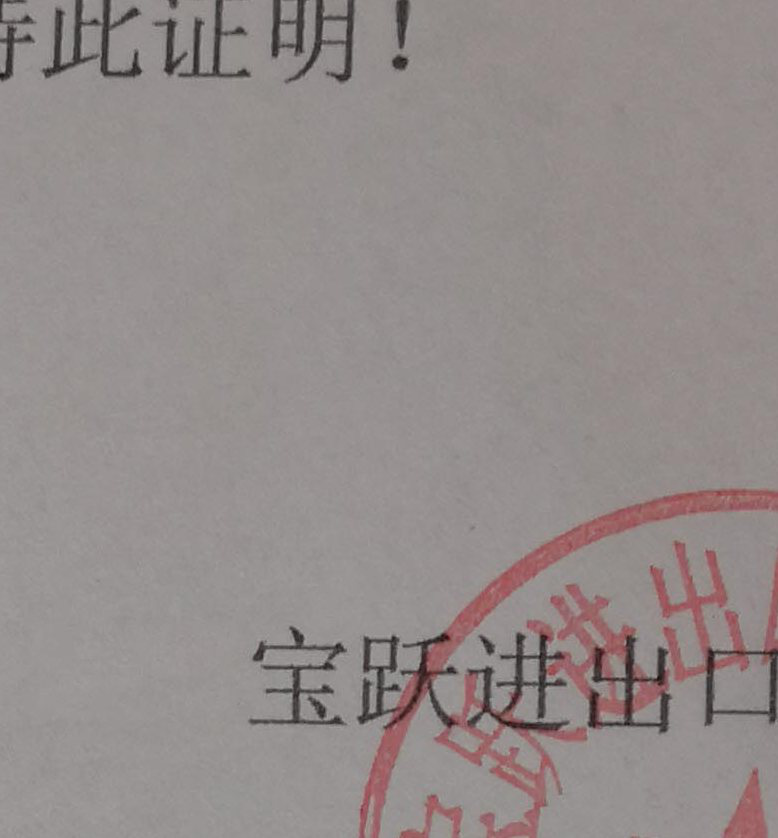

In [163]:
Image.open('/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/img/983.jpg')

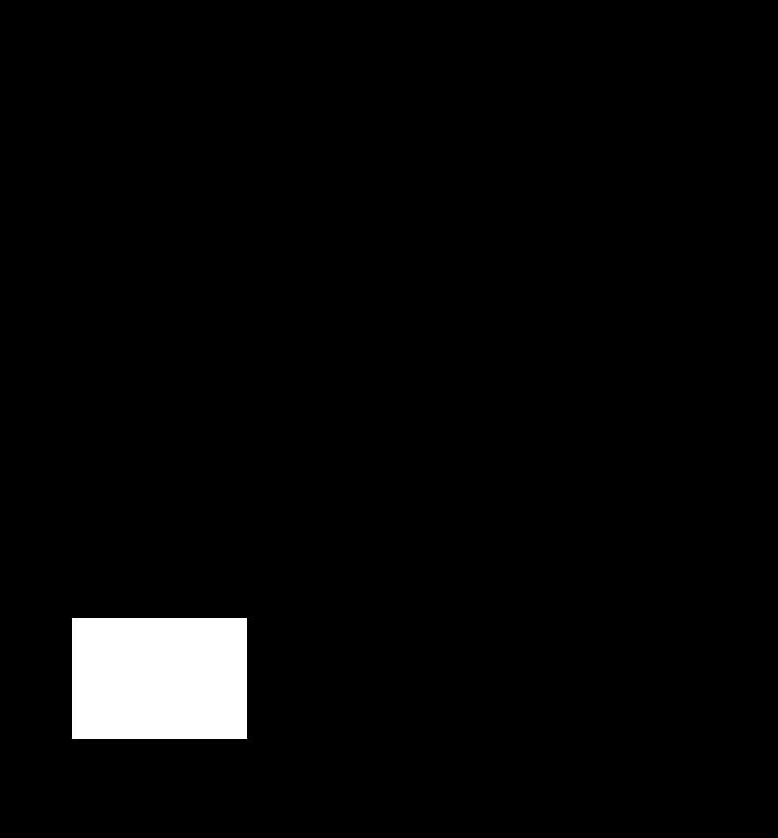

In [164]:
Image.open('/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/mask/983.png')

In [171]:
aa = cv2.imread('/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/masked/988.png')

In [172]:
aa.shape

(900, 570, 3)

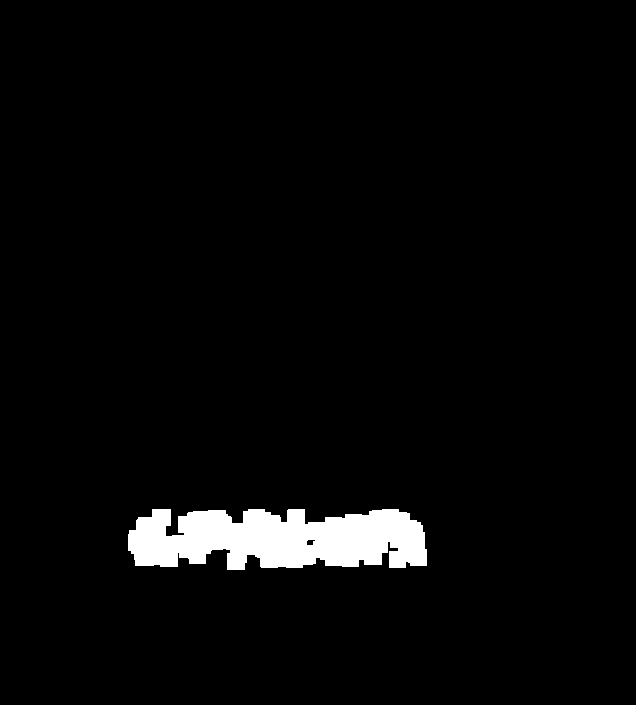

In [66]:
Image.fromarray(aa*255)

## 003_tianchi_2023TTI

不固定大小，较大

imgs图片

masks0-255mask

In [68]:
path0 = '/data/jinrong/wcw/PS/data/003_tianchi_2023TTI/train/tampered/imgs/'
path1 = '/data/jinrong/wcw/PS/data/003_tianchi_2023TTI/train/tampered/masks/'

In [69]:
image_list = [os.path.join(path0,x) for x in os.listdir(path0)]
label_list = [os.path.join(path1,x) for x in os.listdir(path1)]

In [173]:
aa = Image.open('/data/jinrong/wcw/PS/data/003_tianchi_2023TTI/train/tampered/imgs/0089.jpg')

In [174]:
aa.size

(1080, 2340)

In [192]:
aa = cv2.imread('/data/jinrong/wcw/PS/data/003_tianchi_2023TTI/train/tampered/masks/0089.png')
aa.shape

(2340, 1080, 3)

## 004_tianchi_securityAI_long

不固定大小

In [80]:
path0 = '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train/'
path1 = '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/'

In [81]:
image_list = [os.path.join(path0,x) for x in os.listdir(path0)]
label_list = [os.path.join(path1,x) for x in os.listdir(path1)]

In [86]:
label_list

['/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/984.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/926.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/563.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/940.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/1705.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/1955.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/1782.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/851.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/203.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/339.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/1703.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/302.png',
 '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/1406.

In [181]:
aa = Image.open('/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train/112.jpg')

In [182]:
aa.size

(300, 300)

In [190]:
aa = cv2.imread('/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask/1126.png')
aa.shape

(1024, 1024, 3)

## 005_tianchi _securityAI_S2

不固定大小

In [89]:
path0 = '/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/train/'
path1 = '/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/train_mask/'

In [90]:
image_list = [os.path.join(path0,x) for x in os.listdir(path0)]
label_list = [os.path.join(path1,x) for x in os.listdir(path1)]

In [91]:
len(image_list)

1001

In [92]:
image_list[0]

'/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/train/814.jpg'

In [183]:
aa = Image.open('/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/train/727.jpg')
aa.size

(1218, 1218)

In [189]:
aa = cv2.imread('/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/train_mask/727.png')
aa.shape

(1218, 1218, 3)

## 006_DocTamperV1

pic_FCD

In [103]:
path0 = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_FCD/image/'
path1 = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_FCD/label/'

In [104]:
image_list = [os.path.join(path0,x) for x in os.listdir(path0)]
label_list = [os.path.join(path1,x) for x in os.listdir(path1)]

In [105]:
len(image_list)

2000

In [116]:
label_list[8]

'/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_SCD/label/label_000007046.png'

In [184]:
aa = Image.open('/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_FCD/image/image_000000046.jpg')
aa.size

(512, 512)

In [188]:
aa = cv2.imread('/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_FCD/label/label_000001046.png')
aa.shape

(512, 512, 3)

pic_SCD

In [111]:
path0 = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_SCD/image/'
path1 = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_SCD/label/'

In [112]:
image_list = [os.path.join(path0,x) for x in os.listdir(path0)]
label_list = [os.path.join(path1,x) for x in os.listdir(path1)]

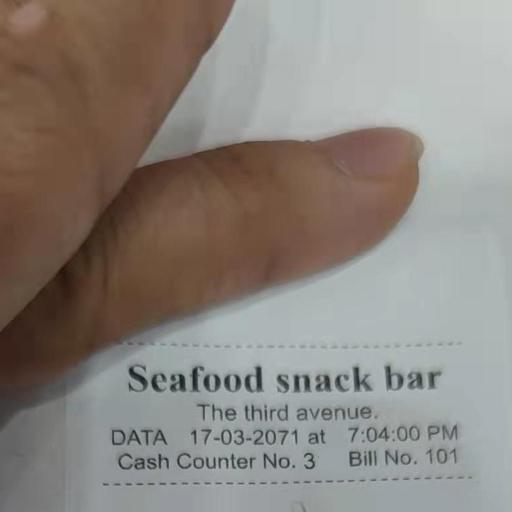

In [135]:
Image.open('/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_SCD/image/image_000007777.jpg')

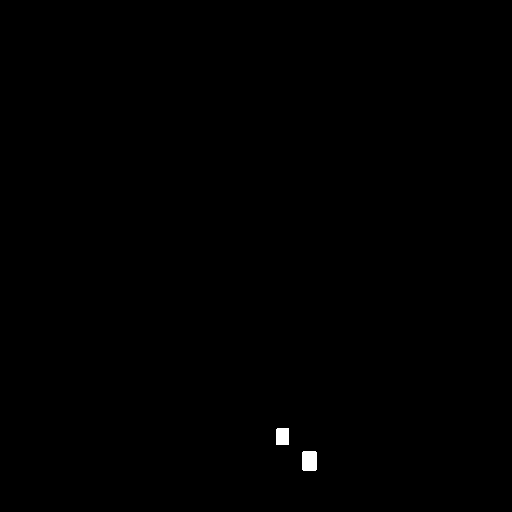

In [136]:
Image.open('/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_SCD/label/label_000007777.png')

pic_train

In [121]:
path0 = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_train/image/'
path1 = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_train/label/'

In [122]:
image_list = [os.path.join(path0,x) for x in os.listdir(path0)]
label_list = [os.path.join(path1,x) for x in os.listdir(path1)]

In [123]:
image_list[0]

'/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_train/image/image_000037597.jpg'

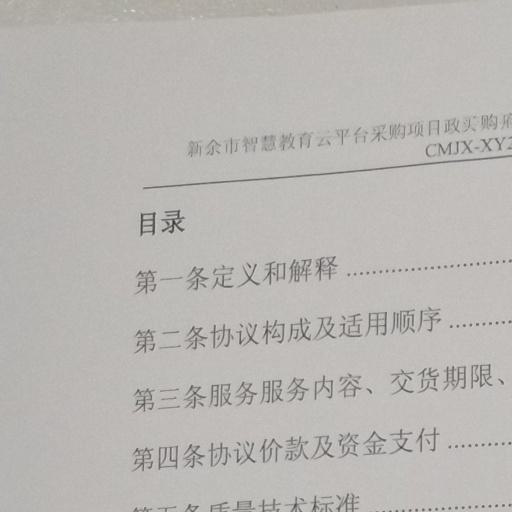

In [139]:
Image.open('/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_train/image/image_000027687.jpg')

In [187]:
aa = cv2.imread('/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_train/label/label_000037597.png')
aa.shape

(512, 512, 3)

pic_test

In [ ]:
path0 = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_test/image/'
path1 = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_test/label/'

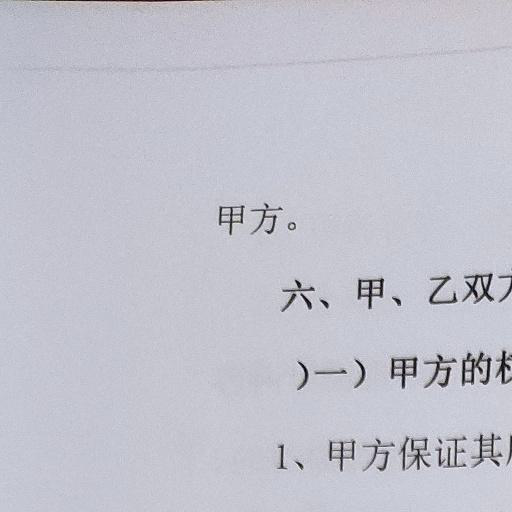

In [128]:
Image.open('/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_test/image/image_000007597.jpg')

In [186]:
aa = cv2.imread('/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_test/label/label_000007597.png')
aa.shape

(512, 512, 3)

# 处理数据集

In [246]:
import os
import cv2
import numpy as np
import tqdm
def process_dataset(image_dir, label_dir, output_dir, patch_size=512, stride=512):
    '''
    将原图和mask图切为512*512大小的patch，并去掉无用的patch
    '''
    # 确保输出目录存在
    output_image_dir = os.path.join(output_dir,'image')
    output_label_dir = os.path.join(output_dir,'label')
    if not os.path.exists(output_image_dir):
        os.makedirs(output_image_dir)
    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)
    
    print(output_image_dir, output_label_dir)
    # 获取image目录下所有图片的路径
    image_files = os.listdir(image_dir)
    
    for image_file in tqdm.tqdm(image_files):
        # 构建图片和mask标签的路径
        if '.jpg' in image_file or '.png' in image_file:
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, image_file.replace('.jpg', '.png').replace('image','label'))

            # 读取原图和mask标签
            image = cv2.imread(image_path)
            label = cv2.imread(label_path)

            # 获取图片尺寸
            height, width, channel = image.shape
            assert channel==3

             # 计算填充后的尺寸
            pad_height = patch_size - height % patch_size if height % patch_size != 0 else 0
            pad_width = patch_size - width % patch_size if width % patch_size != 0 else 0

            # 填充原图和标签
            image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=(0, 0, 0))
            label = cv2.copyMakeBorder(label, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=(0, 0, 0))

            # 获取填充后的图片尺寸
            padded_height, padded_width = image.shape[:2]

            # 遍历原图，切片并保存
            patch_index = 0
            for y in range(0, height - patch_size + 1, stride):
                for x in range(0, width - patch_size + 1, stride):
                    # 获取patch
                    image_patch = image[y:y+patch_size, x:x+patch_size]
                    label_patch = label[y:y+patch_size, x:x+patch_size]

                    # 检查mask标签patch是否存在mask值
                    if np.any(label_patch == 255):
                        # 保存patch
                        patch_image_name = f'{image_file[:-4]}_patch{patch_index}.jpg'.replace('image_','')
                        patch_label_name = f'{image_file[:-4]}_patch{patch_index}.png'.replace('image_','')
                        image_patch_path = os.path.join(output_image_dir, patch_image_name)
                        label_patch_path = os.path.join(output_label_dir, patch_label_name)
                        cv2.imwrite(image_patch_path, image_patch)
                        cv2.imwrite(label_patch_path, label_patch)
                        patch_index += 1
        else:
            pass

In [213]:
image_dir = '/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/img/'
label_dir = '/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/mask/'
output_dir = '/data/jinrong/wcw/PS/data/002_tianchi_2022_RIFLC/patch/'

In [211]:
image_dir = '/data/jinrong/wcw/PS/data/003_tianchi_2023TTI/train/tampered/imgs/'
label_dir = '/data/jinrong/wcw/PS/data/003_tianchi_2023TTI/train/tampered/masks/'
output_dir = '/data/jinrong/wcw/PS/data/003_tianchi_2023TTI/train/tampered/patch'

In [216]:
image_dir = '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train/'
label_dir = '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/train_mask'
output_dir = '/data/jinrong/wcw/PS/data/004_tianchi_securityAI_long/patch'

In [223]:
image_dir = '/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/train/'
label_dir = '/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/train_mask/'
output_dir = '/data/jinrong/wcw/PS/data/005_tianchi_securityAI_S2/data/patch/'

In [255]:
image_dir = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_train/image'
label_dir = '/data/jinrong/wcw/PS/data/006_DocTamperV1/pic_train/label'
output_dir = '/data/jinrong/wcw/PS/data//006_DocTamperV1/pic_train/patch'

In [256]:
process_dataset(image_dir=image_dir, label_dir=label_dir, output_dir=output_dir)

/data/jinrong/wcw/PS/data//006_DocTamperV1/pic_train/patch/image /data/jinrong/wcw/PS/data//006_DocTamperV1/pic_train/patch/label


100%|██████████| 120000/120000 [23:02<00:00, 86.79it/s]
